### Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

#### Restaurant_id — идентификационный номер ресторана / сети ресторанов;
#### City — город, в котором находится ресторан;
#### Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
#### Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
#### Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
#### Price Range — диапазон цен в ресторане;
#### Number of Reviews — количество отзывов о ресторане;
#### Reviews — данные о последних двух отзывах, которые отображаются на сайте ресторана;
#### URL_TA — URL страницы ресторана на TripAdvosor;
#### ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import europe_countries_info  # Файл из GitHub с данными по городам и странам Европы (доработан)

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Библиотеки для нормирования выбоки
from sklearn.preprocessing import MinMaxScaler   # MinMax
from sklearn.preprocessing import StandardScaler # STD

In [3]:
# Специальный инструмент для разбивки
from sklearn.model_selection import train_test_split

# Необходимые библиотеки для модели
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [4]:
# Функция оцифровки ценового диапазона ресторана: 1-низкий, 2-средний, 3-высокий (для признака price_range)
def price_range_to_digit(symbol):
    if symbol == '$': return 1
    elif symbol == '$$ - $$$': return 2
    else: return 3

    
# Функция вычисления и установки среднего значения городского рейтинга (для признака ranking)
def change_ranking(id):
    df_temp = df[df.id_ta == id]
        
    rank_mean = round(df_temp.ranking.mean()) # Вычисляем среднее значение городского рейтинга для пары
    for i in df_temp.index:
        df.at[i, 'ranking'] = rank_mean # Заменяем значение городского рейтинга

        
# Функция перевода стилей кухни из строковой переменной в список (для признака cuisine_style)
def cusine_to_list(item):
    if ',' in item: # Стилей кухни больше одной
        return item[2:-2].split("', '") # Выделяем стили кухни, разделенных запятой
    
    else: # Кухня одна
        aa = []
        aa.append(item[2:-2])
        
        return aa

In [5]:
# Функция очиски количественных признаков от выбросов
def clear_sign_num(sign):
    sign_dscrb = df[sign].describe()
    delta = (sign_dscrb[6] - sign_dscrb[4])*1.5 # Рассчитываем межквартильный порог
    top_board = sign_dscrb[6] + delta # Верхняя граница выбросов
    bot_board = sign_dscrb[4] - delta # Нижняя граница выбросов
        
    # Очищаем по нижней границе
    df.drop(df[(df[sign] < bot_board)].index, axis= 0, inplace= True) 
    # Очищаем по верхней границе     
    df.drop(df[(df[sign] > top_board)].index, axis= 0, inplace= True) 

In [6]:
# Функция очиски номинативных признаков от выбросов
def clear_sign(sign):
    len_df = 0
    while len(df) != len_df: # Выполняем, пока есть выбросы
        len_df = len(df) # Запоминаем текущую длину датафрейма
        for item in df[sign].value_counts().index: # Перебор признака по списку
            sign_dscrb = df[df[sign] == item].rating.describe()
            delta = (sign_dscrb[6] - sign_dscrb[4])*1.5 # Рассчитываем межквартильный порог
            top_board = sign_dscrb[6] + delta # Верхняя граница выбросов
            bot_board = sign_dscrb[4] - delta # Нижняя граница выбросов
            # Очищаем по нижней границе
            df.drop(df[(df[sign] == item) & (df.rating < bot_board)].index, axis= 0, inplace= True) 
            # Очищаем по верхней границе     
            df.drop(df[(df[sign] == item) & (df.rating > top_board)].index, axis= 0, inplace= True) 

In [7]:
# Функция определения столицы государства по названию города
def find_capital(item):
    if item in list(df_cities['capital']): return 1
    return 0

In [8]:
# Функция определения государства по названию города
def find_country(item):
    i = 0
    for city in df_cities['cities']:
        if item in city: return df_cities.iloc[i]['country']
        i += 1

In [9]:
# Функция определения региона по названию города
def find_region(item):
    i = 0
    for city in df_cities['cities']:
        if item in city: return df_cities.iloc[i]['region']
        i += 1

In [10]:
# Функция извлечения дат из отзывов. Возвращает дату последнего отзыва или nan, когда отзывов нет (исп. для признака reviews)
def last_date_review(line):
    if len(line) < 10: return np.nan  # Если отзывов нет, возвращаем nan
    else:
        i = line.rfind("['")  # Находим начало записи дат
        dat_cont = line[i+2:-3]  # Выделяем контейнер с датами
        
        if ',' in dat_cont:  # Дат больше одной
            str_date = []
            str_date = dat_cont.split("', '")  # Выделяем даты, разделенные запятой
            list_date = pd.to_datetime(str_date, format='%m/%d/%Y')  # Преобразуем выделенные данные в формат datetime
            
            # Выделяем и возвращаем дату последнего отзыва
            if list_date[0] > list_date[1]:
                return list_date[0]
            return list_date[1]
        
        else: # Дата одна
            return pd.to_datetime(dat_cont, format='%m/%d/%Y')

In [11]:
# Функция определения среднего количества стилей кухни по городам и составления топового списка стилей кухни
def top_list(city_list):
    cus_list_all = []
    
    for list_1 in city_list:  # Цикл по ресторанам
        for cusine in list_1:  # Цикл по стилям кухни в одном ресторане
            cus_list_all.append(cusine)  # Суммарный список стилей кухнни в городе
    
    top_count = int(round(len(cus_list_all) / len(city_list)))  # Среднее число стилей кухни по городу
    
    return list(pd.Series(cus_list_all).value_counts().head(top_count).index)  # Возвращаем список топовых кухонь        

In [12]:
# Функция проверки получившейся модели (вынесли сюда для удобства проверки разных моделей)
def estimate_MAE(data, target):
    X = data
    y = target
    
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
    # Для тестирования мы будем использовать 25% от исходного датасета.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    
    # Создаём модель
    model = RandomForestRegressor(n_estimators=100, random_state=123)

    # Обучаем модель на тестовом наборе данных
    model.fit(X_train, y_train)

    # Выводим график значимости признаков для модели
    plt.rcParams['figure.figsize'] = (12,8)
    feat_importances = pd.Series(model.feature_importances_, index = X.columns)
    feat_importances.nlargest(20).plot(kind = 'barh', grid = True, title = 'Значимость признаков для модели')
    
      
    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = model.predict(X_test)
    
    # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
    return metrics.mean_absolute_error(y_test, y_pred)

In [13]:
df = pd.read_csv("main_task.csv")

In [14]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']","5,570.00",3.50,$$ - $$$,194.00,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,"1,537.00",4.00,NaN,10.00,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.00,4.50,$$$$,688.00,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,"3,458.00",5.00,NaN,3.00,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.00,4.00,$$ - $$$,84.00,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


#### Пропущенные значения есть только в 3 признаках: стиль кухни (cuisine_style), ценовой диапазон ресторана (price_range) и количество отзывов (reviews_count)

In [16]:
# Для наглядности выводим пропущенные значения по признакам
for item in df.columns:
    print(item, df[item].isna().sum())

Restaurant_id 0
City 0
Cuisine Style 9283
Ranking 0
Rating 0
Price Range 13886
Number of Reviews 2543
Reviews 0
URL_TA 0
ID_TA 0


In [17]:
# Смотрим наименования столбцов
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA'],
      dtype='object')

In [18]:
# Заменяем наименования столбцов на более удобные для работы
df.columns = ['restaurant_id','city','cuisine_style','ranking','rating','price_range','reviews_count','reviews',
              'url_ta','id_ta']
# Проверяем
df.head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']","5,570.00",3.50,$$ - $$$,194.00,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,"1,537.00",4.00,NaN,10.00,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.00,4.50,$$$$,688.00,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,"3,458.00",5.00,NaN,3.00,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.00,4.00,$$ - $$$,84.00,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [19]:
df.rating.value_counts()

4.00    13692
4.50    10929
3.50     6824
5.00     3879
3.00     2955
2.50      915
2.00      466
1.00      201
1.50      139
Name: rating, dtype: int64

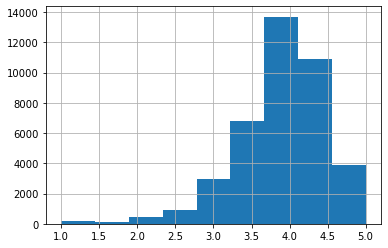

In [20]:
df.rating.hist(bins=9)

In [21]:
df.rating.describe()

count   40,000.00
mean         3.99
std          0.67
min          1.00
25%          3.50
50%          4.00
75%          4.50
max          5.00
Name: rating, dtype: float64

In [22]:
# Производим очистку данных от выбросов
#clear_sign_num('rating')

# Приступаем к очистке данных

## Проверяем дублирование записей по базе данных TripAdvisor

In [23]:
# Смотрим, сколько записей в базе данных ресторанов TripAdvisor могут иметь дублирование
(df.id_ta.value_counts() > 1).sum()

20

####  Получилось 20 дублированных записей

In [24]:
# Смотрим идентификационные номера дублированных записей
df_vc = df.id_ta.value_counts().head(20)
df_vc

d10047799    2
d3161682     2
d11921719    2
d9877640     2
d13002276    2
d697406      2
d793170      2
d987900      2
d11674463    2
d2477531     2
d8753348     2
d7809594     2
d7342803     2
d9802625     2
d4600226     2
d1315077     2
d11698990    2
d7337366     2
d11999956    2
d3685055     2
Name: id_ta, dtype: int64

In [25]:
# Анализируем полученные результаты
for id in df_vc.index:
    display(df[df.id_ta == id])

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13980,id_3239,Madrid,NaN,"3,241.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799
38946,id_3242,Madrid,NaN,"3,244.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
25251,id_3575,Madrid,"['Spanish', 'Bar']","3,577.00",3.50,$,217.00,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682
39847,id_3709,Madrid,"['Spanish', 'Bar']","3,711.00",3.50,$,217.00,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10819,id_2197,Madrid,NaN,"2,199.00",4.50,NaN,16.00,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719
12628,id_2329,Madrid,NaN,"2,331.00",4.50,NaN,16.00,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15295,id_475,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",476.00,4.50,$$ - $$$,67.00,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640
15565,id_530,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",531.00,4.50,$$ - $$$,67.00,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
1579,id_2673,Madrid,['American'],"2,675.00",5.00,$,6.00,"[['Healthy vegan doughnuts are posible', 'Best...",/Restaurant_Review-g187514-d13002276-Reviews-D...,d13002276
26696,id_2485,Madrid,['American'],"2,487.00",5.00,$,6.00,"[['Healthy vegan doughnuts are posible', 'Best...",/Restaurant_Review-g187514-d13002276-Reviews-D...,d13002276


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4578,id_1180,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...","1,181.00",4.00,$$ - $$$,341.00,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406
28096,id_1209,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...","1,210.00",4.00,$$ - $$$,341.00,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
5240,id_2406,Madrid,"['Italian', 'French', 'European']","2,408.00",4.00,$$ - $$$,148.00,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170
36822,id_2487,Madrid,"['Italian', 'French', 'European']","2,489.00",4.00,$$ - $$$,148.00,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8019,id_2361,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...","2,363.00",4.00,$$ - $$$,190.00,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900
22998,id_2312,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...","2,314.00",4.00,$$ - $$$,190.00,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4732,id_3804,Madrid,"['American', 'German', 'European', 'Central Eu...","3,806.00",4.00,NaN,8.00,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463
11583,id_3810,Madrid,"['American', 'German', 'European', 'Central Eu...","3,812.00",4.00,NaN,8.00,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8421,id_3811,Madrid,['Spanish'],"3,813.00",4.00,$,23.00,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531
24545,id_3805,Madrid,['Spanish'],"3,807.00",4.00,$,23.00,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13942,id_1103,Madrid,['Spanish'],"1,104.00",4.50,$$ - $$$,73.00,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348
31238,id_1212,Madrid,['Spanish'],"1,213.00",4.50,$$ - $$$,73.00,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15525,id_3967,Madrid,"['American', 'Spanish', 'Asian']","3,969.00",3.50,NaN,61.00,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d7809594
19388,id_4331,Madrid,"['American', 'Spanish', 'Asian']","4,333.00",3.50,NaN,61.00,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d7809594


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
22924,id_2359,Madrid,"['Spanish', 'Mediterranean']","2,361.00",4.50,$$ - $$$,16.00,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803
36275,id_2467,Madrid,"['Spanish', 'Mediterranean']","2,469.00",4.50,$$ - $$$,16.00,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10594,id_2677,Madrid,NaN,"2,679.00",5.00,NaN,10.00,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625
12938,id_2486,Madrid,NaN,"2,488.00",5.00,NaN,10.00,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
147,id_4110,Madrid,['Spanish'],"4,112.00",5.00,NaN,2.00,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226
9446,id_4104,Madrid,['Spanish'],"4,106.00",5.00,NaN,2.00,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10439,id_468,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",469.00,4.00,$$ - $$$,355.00,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077
25785,id_511,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",512.00,4.00,$$ - $$$,355.00,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
26431,id_3238,Madrid,NaN,"3,240.00",4.50,NaN,7.00,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990
26551,id_3240,Madrid,NaN,"3,242.00",4.50,NaN,7.00,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10183,id_1225,Madrid,"['Mediterranean', 'European', 'Spanish', 'Vege...","1,227.00",4.00,$$ - $$$,272.00,"[['Simply Excellent!', 'Modern!'], ['10/22/201...",/Restaurant_Review-g187514-d7337366-Reviews-La...,d7337366
32814,id_1197,Madrid,"['Mediterranean', 'European', 'Spanish', 'Vege...","1,198.00",4.00,$$ - $$$,272.00,"[['Simply Excellent!', 'Modern!'], ['10/22/201...",/Restaurant_Review-g187514-d7337366-Reviews-La...,d7337366


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
16920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...","3,538.00",4.00,$$ - $$$,52.00,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956
29879,id_3662,Madrid,"['International', 'Mediterranean', 'Spanish', ...","3,664.00",4.00,$$ - $$$,52.00,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
3942,id_5646,Madrid,"['Lebanese', 'Mediterranean', 'Middle Eastern'...","5,649.00",3.50,$$ - $$$,443.00,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055
27680,id_5617,Madrid,"['Lebanese', 'Mediterranean', 'Middle Eastern'...","5,620.00",3.50,$$ - $$$,443.00,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055


#### Видно, что все продублированные рестораны находятся в одном городе (Мадрид) и имеют практически абсолютно одинаковые параметры за исключением принадлежности к разным сетям ресторанов (rest_id) и  разного рейтинга внутри города (хотя, он очень близкий)
#### Таким образом, у нас имеется однозначно 20 дублей, получившихся по непонятной причине. Если проанализировать сети, куда данные рестораны входят, то практически невозможно точно определить, к какой же конкретно сети всё-таки принадлежит каждый из дублированных ресторанов.

In [26]:
#  Например, посмотрим данные для первого ресторана (d10047799) с идентификационными номерами id_3239 и id_3242
df[df.restaurant_id == 'id_3239']

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
3267,id_3239,Prague,"['American', 'Fast Food']","3,246.00",3.50,$,59.00,"[['You can do better', 'Worst customer service...",/Restaurant_Review-g274707-d4768666-Reviews-KF...,d4768666
7253,id_3239,Lisbon,"['European', 'Portuguese']","3,243.00",4.00,NaN,40.00,"[['Unexpected gem', 'Great food!'], ['05/08/20...",/Restaurant_Review-g189158-d1519119-Reviews-Re...,d1519119
9478,id_3239,Vienna,['Fast Food'],"3,241.00",3.00,$,43.00,"[['Omg', 'Loved the fact we could order bespok...",/Restaurant_Review-g190454-d1997490-Reviews-Mc...,d1997490
12134,id_3239,Barcelona,"['Cafe', 'Mediterranean', 'European', 'Pizza',...","3,240.00",4.00,$$ - $$$,64.00,"[['More than good', 'Healthy food'], ['08/16/2...",/Restaurant_Review-g187497-d7205454-Reviews-Me...,d7205454
13980,id_3239,Madrid,NaN,"3,241.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799
23217,id_3239,London,"['Fast Food', 'European', 'Portuguese']","3,246.00",4.00,$$ - $$$,219.00,"[['Always a THUMB up', 'Great chicken from the...",/Restaurant_Review-g186338-d1021861-Reviews-Na...,d1021861
29500,id_3239,Berlin,"['Japanese', 'Sushi', 'Asian', 'Fusion']","3,241.00",5.00,$$ - $$$,nan,"[[], []]",/Restaurant_Review-g187323-d12807643-Reviews-O...,d12807643
39853,id_3239,Paris,NaN,"3,240.00",4.50,NaN,43.00,"[['Deliciousness', 'Romantic and delicious'], ...",/Restaurant_Review-g187147-d10248508-Reviews-J...,d10248508


In [27]:
df[df.restaurant_id == 'id_3242']

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8854,id_3242,London,"['Japanese', 'Vegetarian Friendly']","3,249.00",5.00,$$ - $$$,16.00,"[['Best Ramen I’ve had outside of Japan!', 'Th...",/Restaurant_Review-g186338-d12874584-Reviews-M...,d12874584
9854,id_3242,Vienna,"['Italian', 'Pizza', 'Grill']","3,244.00",3.00,$$ - $$$,6.00,[['A place to enjoy eating any time of the da....,/Restaurant_Review-g190454-d6827920-Reviews-De...,d6827920
12465,id_3242,Prague,"['Czech', 'Bar', 'European']","3,249.00",4.00,$$ - $$$,30.00,"[['Not worth it', 'Eating Good With the locals...",/Restaurant_Review-g274707-d3598472-Reviews-U_...,d3598472
25798,id_3242,Berlin,NaN,"3,244.00",5.00,NaN,3.00,"[['Friendly and quirky bar', 'POSH Teckel'], [...",/Restaurant_Review-g187323-d7251843-Reviews-Po...,d7251843
33832,id_3242,Lisbon,NaN,"3,246.00",3.50,NaN,10.00,"[['Alright', 'Pao de Deus is my new favorite']...",/Restaurant_Review-g189158-d10248474-Reviews-P...,d10248474
38946,id_3242,Madrid,NaN,"3,244.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799


#### Понять, к какой конкретно сети относится данный ресторан невозможно (для других 19 ресторанов из списка такая же картина), поэтому поступаем следующим образом: городской рейтинг усредняем для каждой пары, после чего удаляем дублированные записи по признаку "id_ta"

In [28]:
# Замена значений городского рейтинга в дублированных записях на среднее значение пары
for id in df_vc.index:
    change_ranking(id)
    display(df[df.id_ta == id])

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13980,id_3239,Madrid,NaN,"3,242.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799
38946,id_3242,Madrid,NaN,"3,242.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
25251,id_3575,Madrid,"['Spanish', 'Bar']","3,644.00",3.50,$,217.00,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682
39847,id_3709,Madrid,"['Spanish', 'Bar']","3,644.00",3.50,$,217.00,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10819,id_2197,Madrid,NaN,"2,265.00",4.50,NaN,16.00,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719
12628,id_2329,Madrid,NaN,"2,265.00",4.50,NaN,16.00,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15295,id_475,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",504.00,4.50,$$ - $$$,67.00,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640
15565,id_530,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",504.00,4.50,$$ - $$$,67.00,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
1579,id_2673,Madrid,['American'],"2,581.00",5.00,$,6.00,"[['Healthy vegan doughnuts are posible', 'Best...",/Restaurant_Review-g187514-d13002276-Reviews-D...,d13002276
26696,id_2485,Madrid,['American'],"2,581.00",5.00,$,6.00,"[['Healthy vegan doughnuts are posible', 'Best...",/Restaurant_Review-g187514-d13002276-Reviews-D...,d13002276


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4578,id_1180,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...","1,196.00",4.00,$$ - $$$,341.00,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406
28096,id_1209,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...","1,196.00",4.00,$$ - $$$,341.00,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
5240,id_2406,Madrid,"['Italian', 'French', 'European']","2,448.00",4.00,$$ - $$$,148.00,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170
36822,id_2487,Madrid,"['Italian', 'French', 'European']","2,448.00",4.00,$$ - $$$,148.00,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8019,id_2361,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...","2,338.00",4.00,$$ - $$$,190.00,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900
22998,id_2312,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...","2,338.00",4.00,$$ - $$$,190.00,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4732,id_3804,Madrid,"['American', 'German', 'European', 'Central Eu...","3,809.00",4.00,NaN,8.00,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463
11583,id_3810,Madrid,"['American', 'German', 'European', 'Central Eu...","3,809.00",4.00,NaN,8.00,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8421,id_3811,Madrid,['Spanish'],"3,810.00",4.00,$,23.00,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531
24545,id_3805,Madrid,['Spanish'],"3,810.00",4.00,$,23.00,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13942,id_1103,Madrid,['Spanish'],"1,158.00",4.50,$$ - $$$,73.00,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348
31238,id_1212,Madrid,['Spanish'],"1,158.00",4.50,$$ - $$$,73.00,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15525,id_3967,Madrid,"['American', 'Spanish', 'Asian']","4,151.00",3.50,NaN,61.00,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d7809594
19388,id_4331,Madrid,"['American', 'Spanish', 'Asian']","4,151.00",3.50,NaN,61.00,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d7809594


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
22924,id_2359,Madrid,"['Spanish', 'Mediterranean']","2,415.00",4.50,$$ - $$$,16.00,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803
36275,id_2467,Madrid,"['Spanish', 'Mediterranean']","2,415.00",4.50,$$ - $$$,16.00,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10594,id_2677,Madrid,NaN,"2,584.00",5.00,NaN,10.00,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625
12938,id_2486,Madrid,NaN,"2,584.00",5.00,NaN,10.00,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
147,id_4110,Madrid,['Spanish'],"4,109.00",5.00,NaN,2.00,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226
9446,id_4104,Madrid,['Spanish'],"4,109.00",5.00,NaN,2.00,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10439,id_468,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",490.00,4.00,$$ - $$$,355.00,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077
25785,id_511,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",490.00,4.00,$$ - $$$,355.00,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
26431,id_3238,Madrid,NaN,"3,241.00",4.50,NaN,7.00,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990
26551,id_3240,Madrid,NaN,"3,241.00",4.50,NaN,7.00,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10183,id_1225,Madrid,"['Mediterranean', 'European', 'Spanish', 'Vege...","1,212.00",4.00,$$ - $$$,272.00,"[['Simply Excellent!', 'Modern!'], ['10/22/201...",/Restaurant_Review-g187514-d7337366-Reviews-La...,d7337366
32814,id_1197,Madrid,"['Mediterranean', 'European', 'Spanish', 'Vege...","1,212.00",4.00,$$ - $$$,272.00,"[['Simply Excellent!', 'Modern!'], ['10/22/201...",/Restaurant_Review-g187514-d7337366-Reviews-La...,d7337366


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
16920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...","3,601.00",4.00,$$ - $$$,52.00,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956
29879,id_3662,Madrid,"['International', 'Mediterranean', 'Spanish', ...","3,601.00",4.00,$$ - $$$,52.00,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
3942,id_5646,Madrid,"['Lebanese', 'Mediterranean', 'Middle Eastern'...","5,634.00",3.50,$$ - $$$,443.00,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055
27680,id_5617,Madrid,"['Lebanese', 'Mediterranean', 'Middle Eastern'...","5,634.00",3.50,$$ - $$$,443.00,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055


In [29]:
# Удаляем дубли
df.drop_duplicates(subset=['id_ta'], inplace=True)

In [30]:
# Проверяем
for id in df_vc.index:
    display(df[df.id_ta == id])

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13980,id_3239,Madrid,NaN,"3,242.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
25251,id_3575,Madrid,"['Spanish', 'Bar']","3,644.00",3.50,$,217.00,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10819,id_2197,Madrid,NaN,"2,265.00",4.50,NaN,16.00,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15295,id_475,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",504.00,4.50,$$ - $$$,67.00,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
1579,id_2673,Madrid,['American'],"2,581.00",5.00,$,6.00,"[['Healthy vegan doughnuts are posible', 'Best...",/Restaurant_Review-g187514-d13002276-Reviews-D...,d13002276


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4578,id_1180,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...","1,196.00",4.00,$$ - $$$,341.00,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
5240,id_2406,Madrid,"['Italian', 'French', 'European']","2,448.00",4.00,$$ - $$$,148.00,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8019,id_2361,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...","2,338.00",4.00,$$ - $$$,190.00,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4732,id_3804,Madrid,"['American', 'German', 'European', 'Central Eu...","3,809.00",4.00,NaN,8.00,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8421,id_3811,Madrid,['Spanish'],"3,810.00",4.00,$,23.00,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13942,id_1103,Madrid,['Spanish'],"1,158.00",4.50,$$ - $$$,73.00,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15525,id_3967,Madrid,"['American', 'Spanish', 'Asian']","4,151.00",3.50,NaN,61.00,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d7809594


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
22924,id_2359,Madrid,"['Spanish', 'Mediterranean']","2,415.00",4.50,$$ - $$$,16.00,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10594,id_2677,Madrid,NaN,"2,584.00",5.00,NaN,10.00,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
147,id_4110,Madrid,['Spanish'],"4,109.00",5.00,NaN,2.00,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10439,id_468,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",490.00,4.00,$$ - $$$,355.00,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
26431,id_3238,Madrid,NaN,"3,241.00",4.50,NaN,7.00,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10183,id_1225,Madrid,"['Mediterranean', 'European', 'Spanish', 'Vege...","1,212.00",4.00,$$ - $$$,272.00,"[['Simply Excellent!', 'Modern!'], ['10/22/201...",/Restaurant_Review-g187514-d7337366-Reviews-La...,d7337366


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
16920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...","3,601.00",4.00,$$ - $$$,52.00,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
3942,id_5646,Madrid,"['Lebanese', 'Mediterranean', 'Middle Eastern'...","5,634.00",3.50,$$ - $$$,443.00,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  39980 non-null  object 
 1   city           39980 non-null  object 
 2   cuisine_style  30701 non-null  object 
 3   ranking        39980 non-null  float64
 4   rating         39980 non-null  float64
 5   price_range    26101 non-null  object 
 6   reviews_count  37437 non-null  float64
 7   reviews        39980 non-null  object 
 8   url_ta         39980 non-null  object 
 9   id_ta          39980 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.4+ MB


### Дублей больше нет. Количество записей, таким образом, уменьшилось на 20

## Работа с признаком price_range (ценовой диапазон)

In [32]:
# Смотрим уникальные значения ценового диапазона
df.price_range.unique()

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [33]:
# Отсутствующее значения ценового диапазона ресторана будем считать самыми низкими
df.price_range.fillna('$', inplace = True)

In [34]:
# "Оцифровываем" признак: '$' - 1, '$$ - $$$' - 2, '$$$$' - 3
df.price_range = df.price_range.apply(price_range_to_digit)

#### Проверяем, что получилось

In [35]:
df.price_range.unique()

array([2, 1, 3])

In [36]:
df.price_range.value_counts()

1    20155
2    18402
3     1423
Name: price_range, dtype: int64

## Работа с признаком reviews_count (количество отзывов)

In [37]:
# Создаем новый столбец с признаком наличия или отсутствия отзывов
df['reviews_sign'] = df.reviews_count.apply(lambda x: 0 if pd.isnull(x) else 1)

In [38]:
df['reviews_sign'].value_counts()

1    37437
0     2543
Name: reviews_sign, dtype: int64

In [39]:
df.reviews_count.describe()

count   37,437.00
mean       124.83
std        295.73
min          2.00
25%          9.00
50%         33.00
75%        115.00
max      9,660.00
Name: reviews_count, dtype: float64

In [40]:
# Заполняем отсутствующие значения количества отзывов минимальным значением (ненулевым)
df.reviews_count.fillna(df.reviews_count.min(), inplace = True)

In [41]:
# Проверяем
df.reviews_count.isna().sum()

0

## Работа с признаком  reviews (отзывы)

In [42]:
# Создаем новый столбец с признаком наличия или отсутствия отзывов
#df['reviews_sign'] = df.reviews.apply(lambda x: 0 if len(x) < 10 else 1)

In [43]:
# Создаем временный столбец с датами последних отзывов и заполняем его (пустые значения делаем nan)
df['last_date_rev'] = df.reviews.apply(last_date_review)

In [44]:
# Определяем дату самого последнего отзыва
max_date = df['last_date_rev'].max()

In [45]:
# Создаем новый столбец с интервалом дат между отзывами и заполняем его
df['delta_date_rev'] = df[df.last_date_rev.notnull()].last_date_rev.apply(lambda x: (max_date - x).days)

In [46]:
#ddr_median = df[df.delta_date_rev.notnull()].delta_date_rev.median()

In [47]:
# Заполняем пропуски самыми частыми значениями
df['delta_date_rev'].fillna(df.delta_date_rev.mean(), inplace = True)

#df['delta_date_rev'].fillna(df.delta_date_rev.value_counts().index[0], inplace = True)
#df['delta_date_rev'].fillna(0, inplace = True)

In [48]:
# Удаляенм временный столбец с с датами последних отзывов
df.drop('last_date_rev', axis = 1, inplace = True)

In [49]:
len(df)

39980

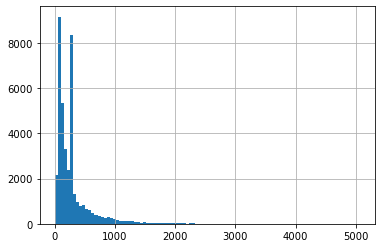

In [50]:
# График распределения нового признака delta_date_rev
df['delta_date_rev'].hist(bins = 100)

In [51]:
df.sample(5)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta,reviews_sign,delta_date_rev
4680,id_1387,Dublin,"['Asian', 'Korean']","1,391.00",4.50,1,5.00,[['Best Authentic Chinese & Korean Food in Du....,/Restaurant_Review-g186605-d4104468-Reviews-Ar...,d4104468,1,"1,545.00"
19308,id_2888,Brussels,"['French', 'Belgian', 'European']","2,889.00",2.50,1,2.00,"[[], []]",/Restaurant_Review-g188644-d694734-Reviews-Maj...,d694734,1,289.41
10573,id_3585,Madrid,NaN,"3,587.00",4.50,1,7.00,"[[], []]",/Restaurant_Review-g187514-d12846131-Reviews-1...,d12846131,1,289.41
2449,id_2488,Barcelona,"['Mediterranean', 'Spanish']","2,489.00",4.00,2,53.00,[['Listened to advice and got seafood paella.....,/Restaurant_Review-g187497-d1065561-Reviews-Do...,d1065561,1,166.00
6455,id_2276,Budapest,NaN,"2,277.00",5.00,1,5.00,"[['Gerbaud', 'Mouse choccolate for dinner'], [...",/Restaurant_Review-g274887-d9716385-Reviews-Cs...,d9716385,1,327.00


In [52]:
# Производим очистку данных от выбросов
clear_sign_num('delta_date_rev')

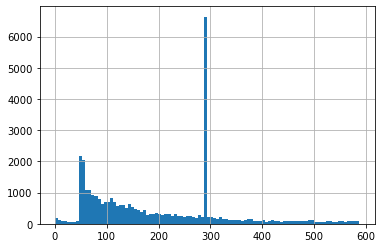

In [53]:
# Проверяем
df['delta_date_rev'].hist(bins = 100)

## Работаем со стилями кухни

#### Блок определения медианного количества стилей кухни в ресторанах и их наименований

In [54]:
# Количество пропущенных значений
df.cuisine_style.isna().sum()

7845

In [55]:
# В пропущенные значения заносим "Cafe"
df['cuisine_style'].fillna("['Cafe']", inplace = True)

In [56]:
# Замена в датафрейме строковой переменной стиля кухни на список
df['cuisine_style'] = df['cuisine_style'][df['cuisine_style'].notnull()].apply(cusine_to_list)

In [57]:
# Собираем все стили кухни в "кучу" и составляем их общий список, список уникальных значений и количественный список
new_column = df['cuisine_style'][df['cuisine_style'].notnull()]  # Столбец с ненулевыми значениями стилей кухни

cusin_list_all = []   # создаём пустой список для хранения полного общего списка значений стилей кухни
cusin_list_count = []  # создаем пустой список для хранения количества стилей кухни по каждому ресторану
cusin_list = set()  # создаём пустое множество для хранения уникальных значений стилей кухни

for item in new_column:  # перебор всех ресторанов
    cusin_list_count.append(len(item)) # заполняем список количества стилей кухни для каждого ресторана
    
    for cus in item:  # перебор стилей кухни
        cusin_list_all.append(cus)  # заполняем полный общий список названий кухни
        cusin_list.add(cus)  # заполняем список уникальных значений

In [58]:
'''
# Заполнение пропущенных значений стилей кухни по городам
for curr_city in list(df.city.value_counts().index):  # Перебор по городам
    #  Список самых популярных стилей кухни в городе
    cus_list = top_list(df[df.city == curr_city].cuisine_style[df.cuisine_style.notnull()])
    # Заполняем пропущенные значения
    for indx in df[df['city'] == curr_city]['cuisine_style'][~df['cuisine_style'].notnull()].index:
        df.at[indx, 'cuisine_style'] = cus_list
'''

"\n# Заполнение пропущенных значений стилей кухни по городам\nfor curr_city in list(df.city.value_counts().index):  # Перебор по городам\n    #  Список самых популярных стилей кухни в городе\n    cus_list = top_list(df[df.city == curr_city].cuisine_style[df.cuisine_style.notnull()])\n    # Заполняем пропущенные значения\n    for indx in df[df['city'] == curr_city]['cuisine_style'][~df['cuisine_style'].notnull()].index:\n        df.at[indx, 'cuisine_style'] = cus_list\n"

In [59]:
# Проверяем
df.cuisine_style.isna().sum()

0

#### Делаем "оцифровку" стилей кухни

In [60]:
# Создаем столбцы для каждого стиля кухни
for item in cusin_list:
    df[item] = df['cuisine_style'].apply(lambda x: 1 if item in x else 0)

In [61]:
# Меняем значения столбца: вместо списка записываем количество предлагаемых рестораном стилей кухни
df['cuisine_style'] = df['cuisine_style'].apply(lambda x: len(x))

In [62]:
# Смотрим, сколько вариантов различной кухни предлагают рестораны
df['cuisine_style'].value_counts()

1     13572
2      5457
3      4984
4      4639
5      3547
6      2025
7      1016
8       282
9        74
10       19
11        3
21        1
13        1
Name: cuisine_style, dtype: int64

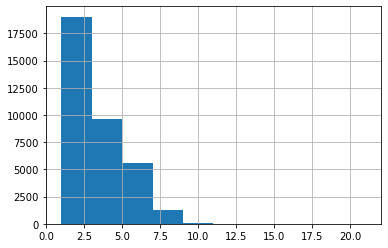

In [63]:
# График распределения
df['cuisine_style'].hist()

In [64]:
# Производим очистку данных от выбросов
clear_sign_num('cuisine_style')

In [65]:
# Проверяем
df['cuisine_style'].value_counts()

1    13572
2     5457
3     4984
4     4639
5     3547
6     2025
7     1016
8      282
Name: cuisine_style, dtype: int64

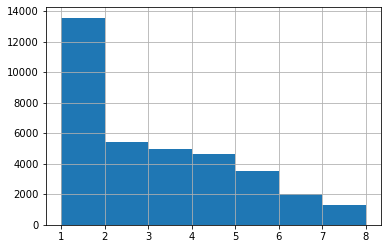

In [66]:
# График распределения
df['cuisine_style'].hist(bins = 7)

## Работа с  городами

In [67]:
# Смотрим, сколько уникальных названий городов
df.city.nunique()

31

In [68]:
# Количество ресторанов в каждом из городов
df.city.value_counts()

London        5290
Paris         4239
Madrid        2737
Barcelona     2434
Rome          1868
Milan         1867
Berlin        1841
Prague        1251
Lisbon        1151
Vienna        1048
Amsterdam     1014
Brussels       943
Hamburg        823
Munich         800
Lyon           775
Budapest       730
Stockholm      693
Dublin         634
Warsaw         627
Copenhagen     599
Edinburgh      561
Athens         543
Zurich         489
Oporto         475
Geneva         411
Krakow         392
Oslo           346
Helsinki       336
Bratislava     256
Luxembourg     191
Ljubljana      158
Name: city, dtype: int64

#### Города не повторяются в различном написании, очистка не требуется

### Анализ признака city

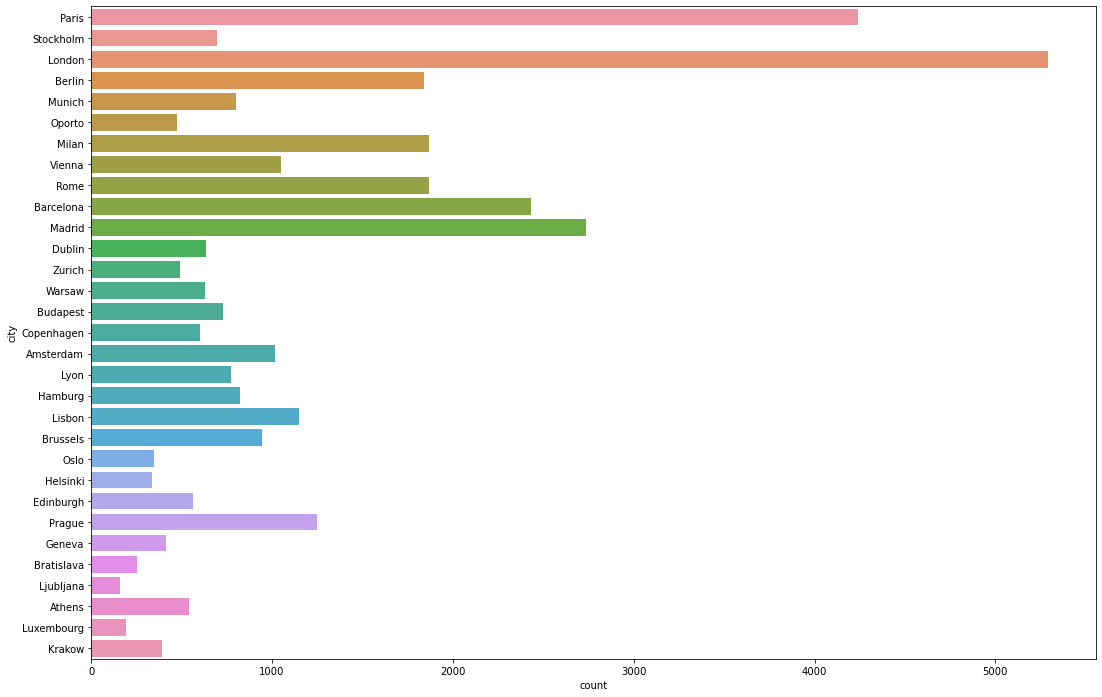

In [70]:
# График распределния ресторанов по городам
fig, ax = plt.subplots(figsize=(18, 12))
sns.countplot(y = 'city', data = df, ax=ax)

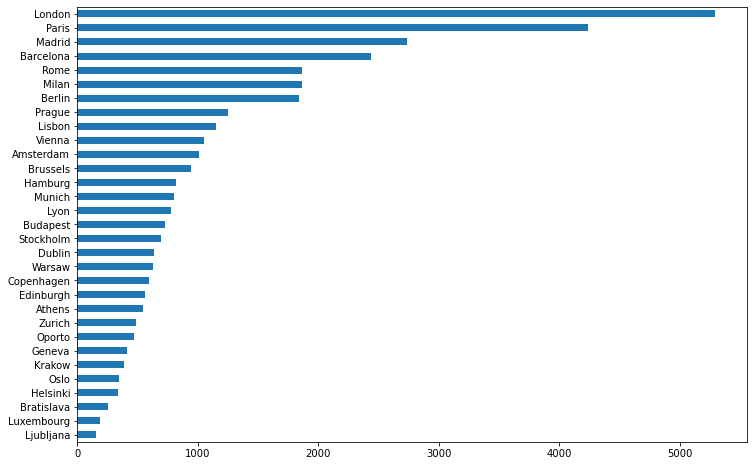

In [71]:
# График распределния ресторанов по городам
fig, ax = plt.subplots(figsize=(12, 8))
df['city'].value_counts(ascending = True).plot(kind = 'barh')

#### Проверяем города на наличие выбросов

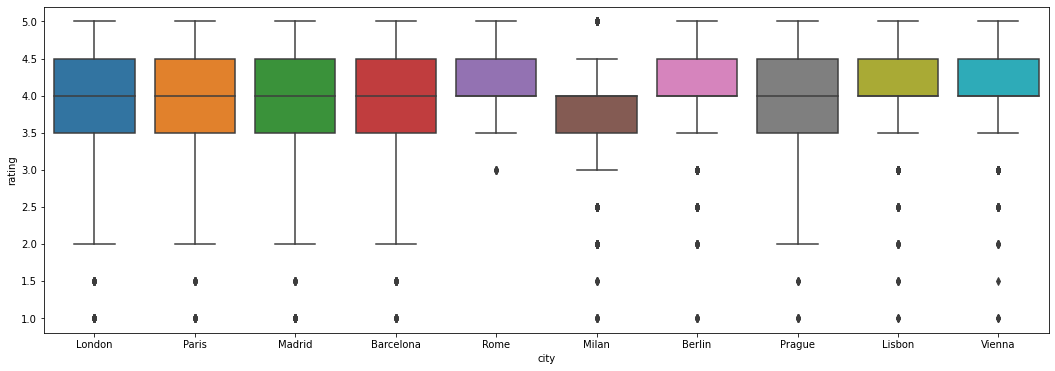

In [72]:
# Построим "коробки с усами" для первых десяти городов из списка
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x='city', y='rating', data=df, order=(df['city'].value_counts())[0:10].index, ax=ax)
plt.show()

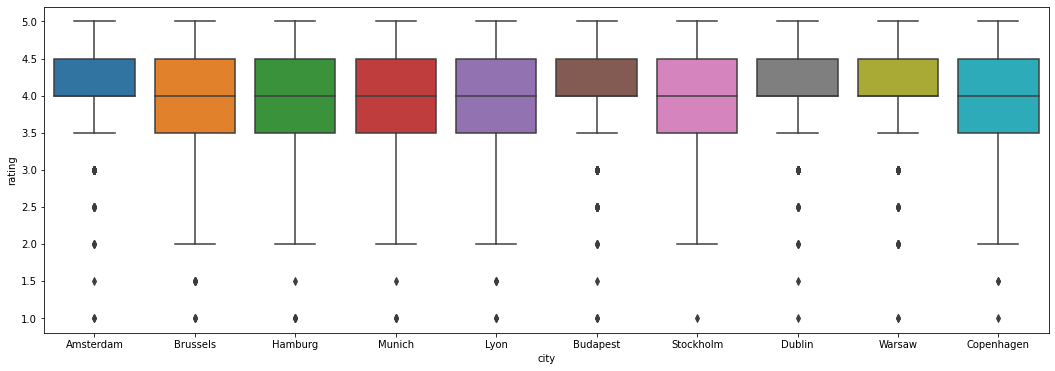

In [73]:
# Построим "коробки с усами" для следующих десяти городов
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x='city', y='rating', data=df, order=(df['city'].value_counts())[10:20].index, ax=ax)
plt.show()

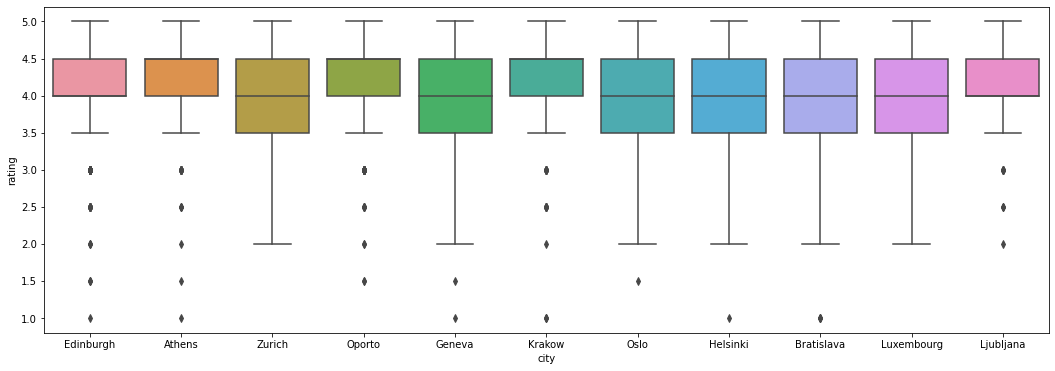

In [74]:
# Построим "коробки с усами" для оставшихся городов
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x='city', y='rating', data=df, order=(df['city'].value_counts())[20:].index, ax=ax)
plt.show()

#### Имеются отдельные выбросы

In [75]:
# Производим очистку данных от выбросов
clear_sign('city')

#### Проверяем результат

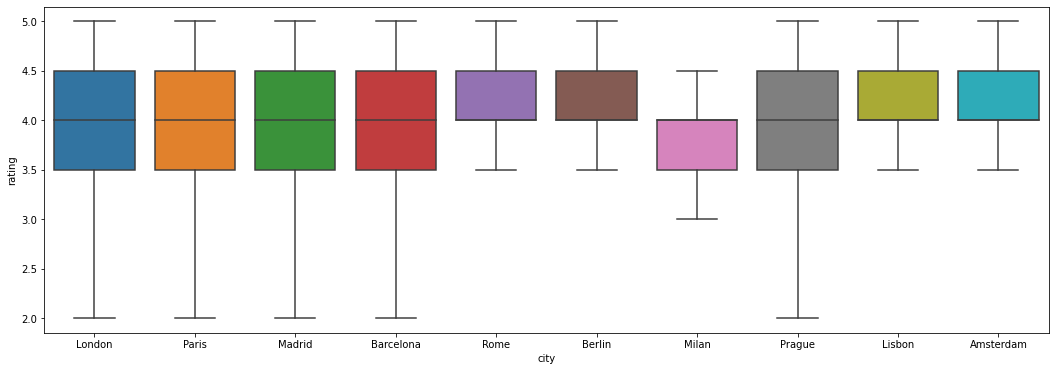

In [76]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="city", y="rating", data=df, order=(df['city'].value_counts())[0:10].index, ax=ax)
plt.show()

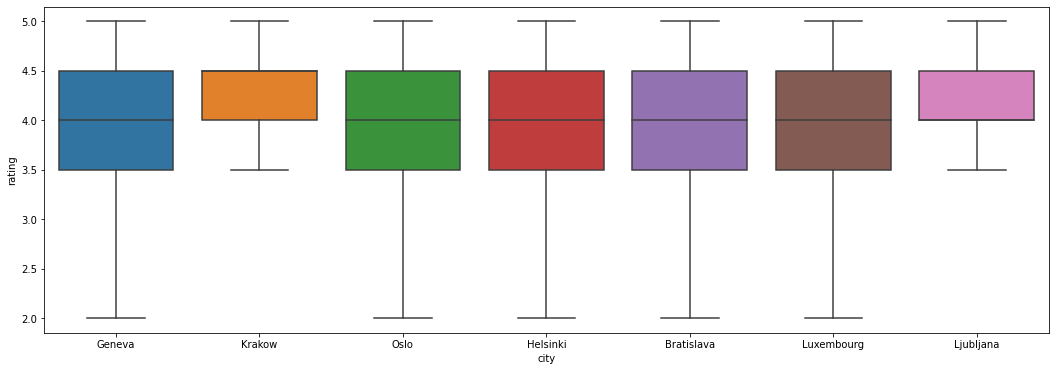

In [77]:
# Построим "коробки с усами" для последних семи городов из списка
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x='city', y='rating', data=df,
                 order=['Geneva', 'Krakow', 'Oslo', 'Helsinki', 'Bratislava', 'Luxembourg', 'Ljubljana'], ax=ax)
plt.show()

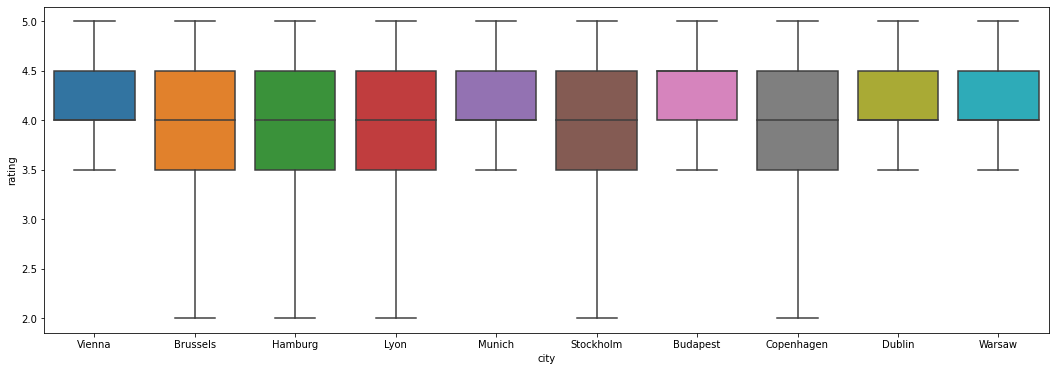

In [78]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="city", y="rating", data=df, order=(df['city'].value_counts())[10:20].index, ax=ax)
plt.show()

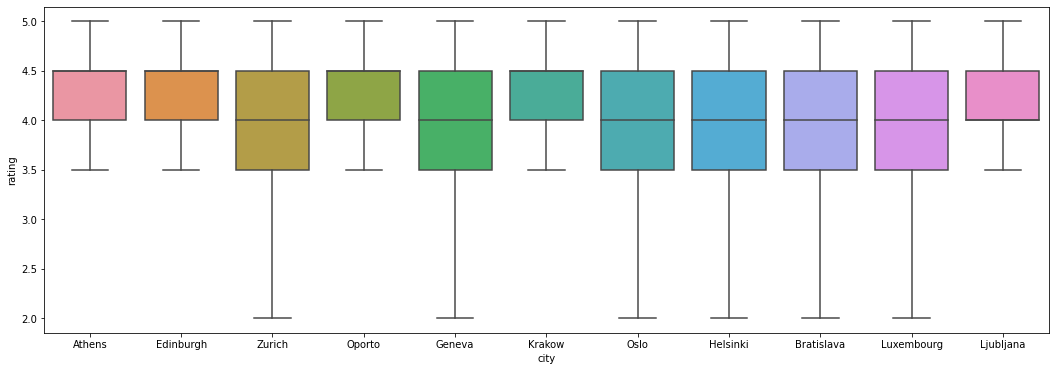

In [79]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="city", y="rating", data=df, order=(df['city'].value_counts())[20:].index, ax=ax)
plt.show()

#### Результат достигнут: выбросов больше нет

### Введём несколько дополнительных признаков. Для работы будем использовать базу данных с городами, столицами и регионами Европы, которая была взята с GitHub и доработана под текущие задачи

In [80]:
#База данных с городами, столицами и регионами Европы
df_cities = pd.DataFrame(europe_countries_info.countries)

#### Вводим новый признак: capital - является ли город столицей государства

In [81]:
df['capital'] = df.city.apply(find_capital)

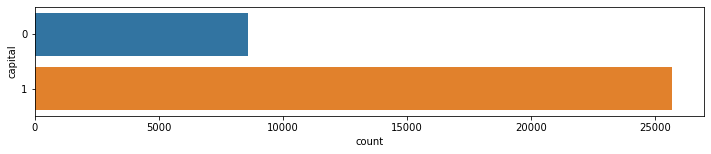

In [82]:
# График, показывающий количество столичных и нестоличных ресторанов
fig, ax = plt.subplots(figsize=(12, 2))
sns.countplot(y = 'capital', data = df, ax=ax)

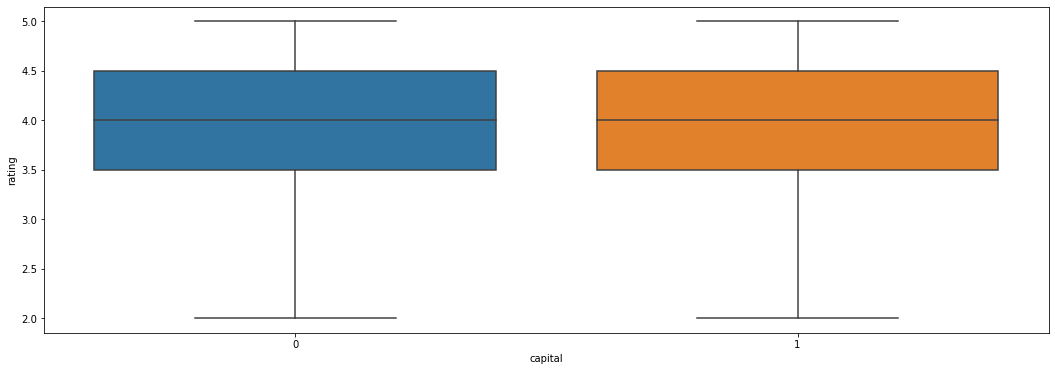

In [83]:
# Построим "коробки с усами" для столичных и нестоличных городов
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x='capital', y='rating', data=df, ax=ax)
plt.show()

#### Выбросов нет, очистка данных не требуется

In [84]:
# Производим очистку данных от выбросов
#clear_sign('capital')

#### Вводим новый признак: country - в какой стране находится город

In [85]:
df['country'] = df.city.apply(find_country)

In [86]:
# Смотрим, в каких странах находятся рестораны из базы данных
df['country'].value_counts()

United Kingdom                5744
Spain                         5085
France                        4971
Italy                         3516
Germany                       3257
Portugal                      1475
Czech Republic                1237
Kingdom of the Netherlands     950
Austria                        948
Poland                         938
Belgium                        933
Switzerland                    898
Sweden                         692
Hungary                        657
Denmark                        596
Republic of Ireland            574
Greece                         521
Norway                         345
Finland                        335
Slovakia                       252
Luxembourg                     191
Slovenia                       147
Name: country, dtype: int64

In [87]:
# Сколько стран
df['country'].nunique()

22

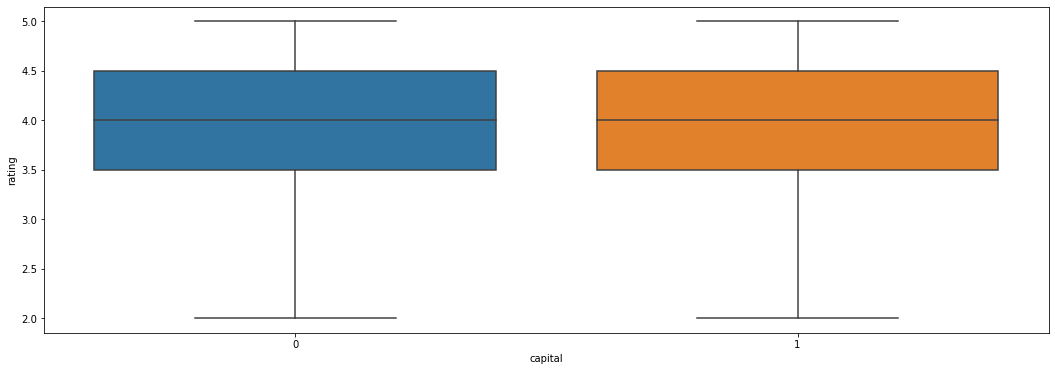

In [88]:
# Проверяем...
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x='capital', y='rating', data=df, ax=ax)
plt.show()

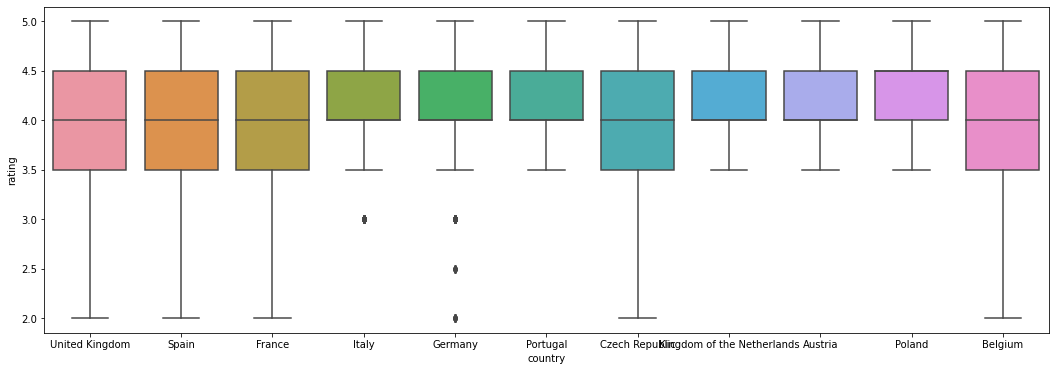

In [89]:
# Построим "коробки с усами" для первых одиннадцати стран из списка
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="country", y="rating", data=df, order=(df['country'].value_counts())[0:11].index, ax=ax)
plt.show()

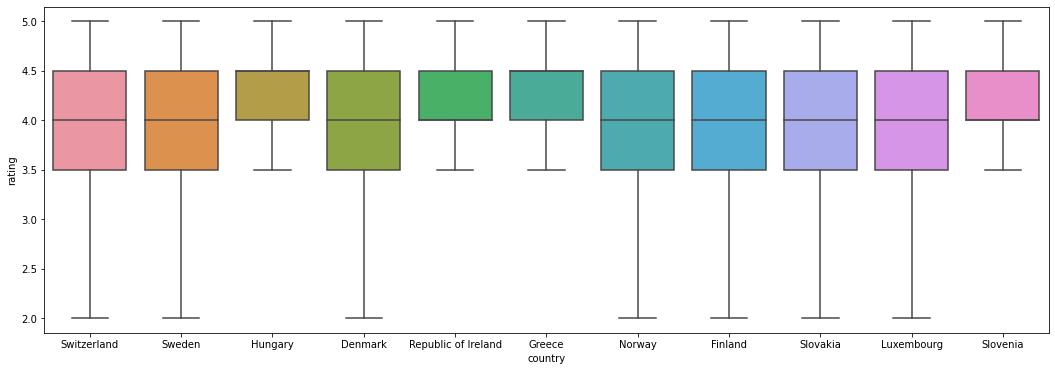

In [90]:
# Построим "коробки с усами" для оставшихся стран
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="country", y="rating", data=df, order=(df['country'].value_counts())[11:].index, ax=ax)
plt.show()

#### Выбросов по странам практически нет

In [91]:
# Производим очистку данных от выбросов
clear_sign('country')

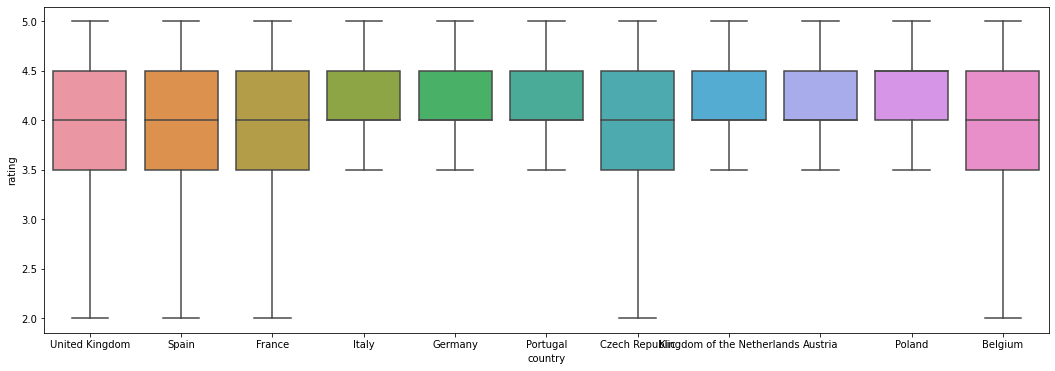

In [92]:
# Выборочно проверяем...
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="country", y="rating", data=df, order=(df['country'].value_counts())[0:11].index, ax=ax)
plt.show()

#### Вводим новый признак: region - Западная, Восточная, Южная или Северная Европа

In [93]:
df['region'] = df.city.apply(find_region)

In [94]:
(df['country'].value_counts())[0:10].index

Index(['United Kingdom', 'Spain', 'France', 'Italy', 'Germany', 'Portugal',
       'Czech Republic', 'Kingdom of the Netherlands', 'Austria', 'Poland'],
      dtype='object')

In [95]:
df['region'].value_counts()

West     12070
South    10571
North     8286
East      3084
Name: region, dtype: int64

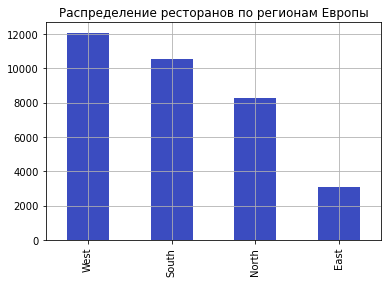

In [96]:
df['region'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение ресторанов по регионам Европы')

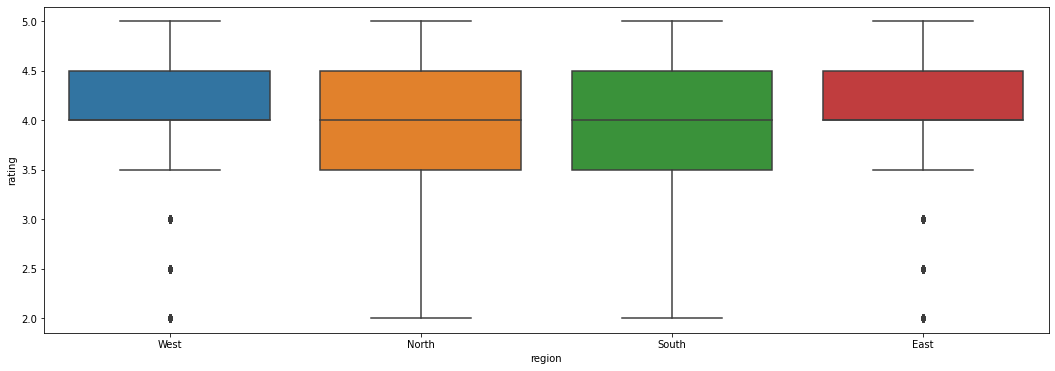

In [97]:
# Построим "коробки с усами" для регионов
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="region", y="rating", data=df, ax=ax)
plt.show()

In [98]:
# Производим очистку данных от выбросов
clear_sign('region')

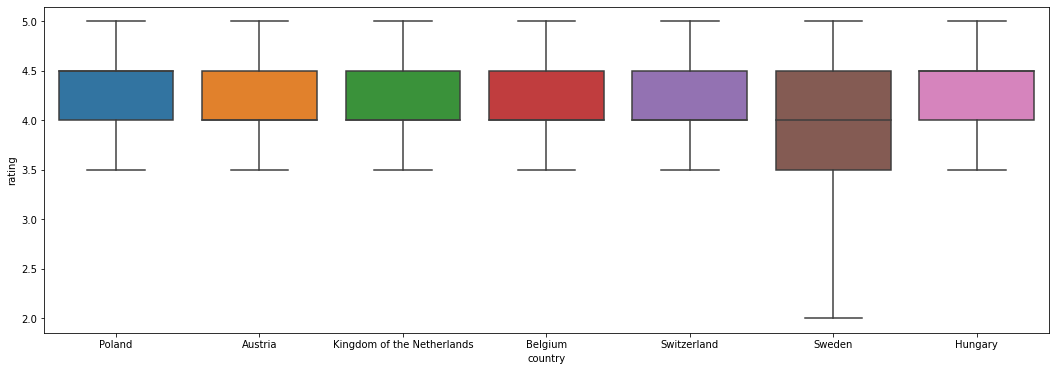

In [99]:
# Построим "коробки с усами" для следующих восьми стран из списка
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="country", y="rating", data=df,
                 order=['Poland', 'Austria', 'Kingdom of the Netherlands', 'Belgium', 'Switzerland', 'Sweden', 
                        'Hungary'], ax=ax)
plt.show()

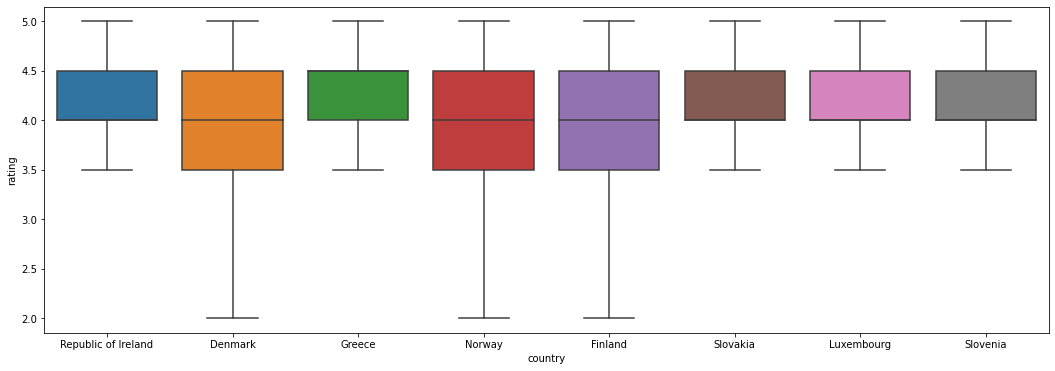

In [100]:
# Построим "коробки с усами" для оставшихся из списка
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="country", y="rating", data=df,
                 order=['Republic of Ireland', 'Denmark', 'Greece', 'Norway', 'Finland', 'Slovakia', 'Luxembourg', 
                        'Slovenia'], ax=ax)
plt.show()

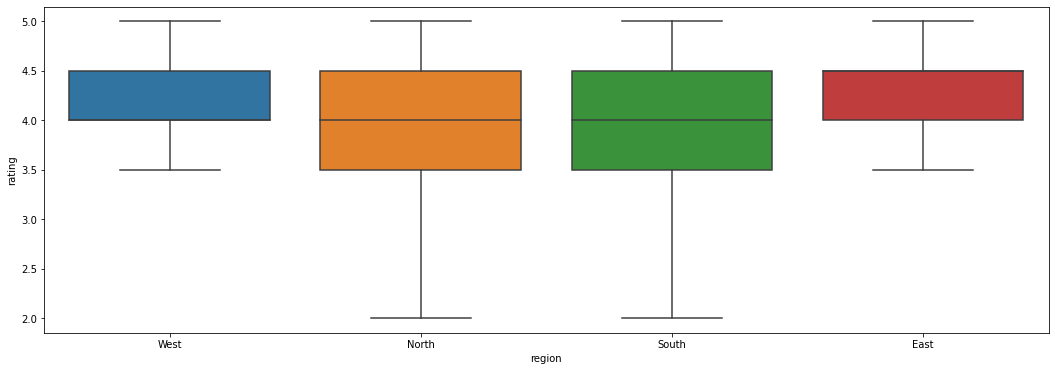

In [101]:
# Проверяем
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="region", y="rating", data=df, ax=ax)
plt.show()

## Работа с признаком ranking

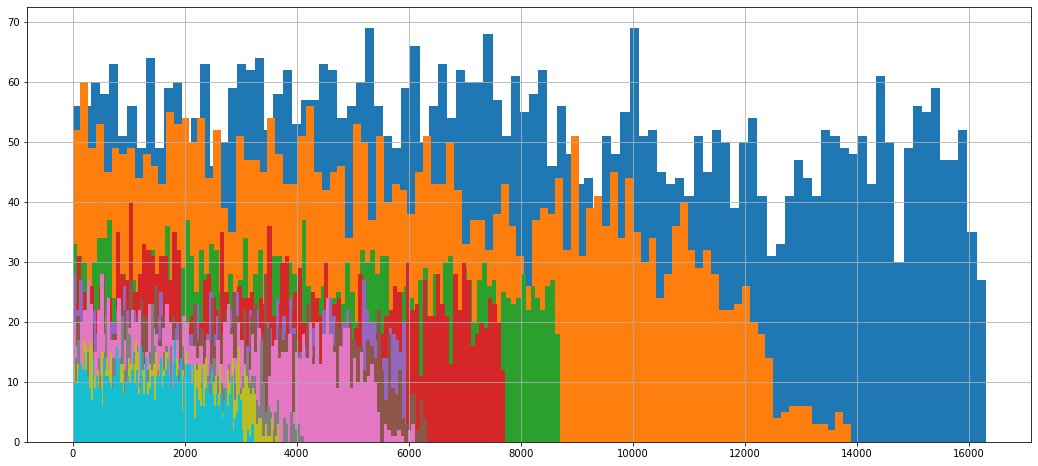

In [102]:
# Выведем графики распределения городского рейтинга для первой десятки городов
fig, ax = plt.subplots(figsize=(18, 8))
for x in (df['city'].value_counts())[0:10].index:
    df['ranking'][df['city'] == x].hist(bins = 100)
plt.show()

#### В городах разное количество ресторанов и, соответственно, разное максимальное значение городского рейтинга (места в городе). Сформируем новый признак, содержащий максимальное значение городского рейтинга

In [103]:
# Создание словаря с максимальным значением рейтинга по городам
rank_max_city = {}
for city in (df['city'].value_counts()).index:
    rank_max_city[city] = df[df['city'] == city]['ranking'].max()

In [104]:
# Создание нового признака
df['rank_max'] = df.apply(lambda x: rank_max_city[x['city']], axis = 1)

### Производим "оцифровку" данных

In [105]:
# "Оцифровываем" города
df = pd.get_dummies(df, columns=['city'])

In [106]:
# "Оцифровываем" страны
df = pd.get_dummies(df, columns=['country'])

In [107]:
# "Оцифровываем" регионы
df = pd.get_dummies(df, columns=['region'])

In [108]:
# Смотрим результат
df.head()

,restaurant_id,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta,reviews_sign,delta_date_rev,Balti,Polish,Slovenian,Malaysian,Japanese,Tunisian,Caribbean,Canadian,Vietnamese,Turkish,Indonesian,Brew Pub,Street Food,Vegetarian Friendly,Latin,Salvadoran,Argentinean,Scandinavian,Spanish,Wine Bar,Southwestern,Egyptian,Xinjiang,Australian,Peruvian,Italian,Hawaiian,Delicatessen,Kosher,Ukrainian,Barbecue,Contemporary,Native American,Moroccan,Chinese,Croatian,Fast Food,Filipino,South American,Swedish,Hungarian,Gluten Free Options,Nepali,Pizza,Polynesian,Lebanese,Brazilian,Danish,Mediterranean,Middle Eastern,Vegan Options,Asian,Indian,Tibetan,Dutch,Russian,Norwegian,Swiss,Fusion,International,Bangladeshi,Halal,Yunnan,Sushi,American,German,Irish,Pakistani,Thai,Israeli,Caucasian,Jamaican,French,Afghani,European,Mexican,Belgian,Portuguese,Seafood,Cuban,Grill,Taiwanese,Singaporean,Cafe,Georgian,Welsh,Cajun & Creole,Central European,Ecuadorean,Ethiopian,Eastern European,Minority Chinese,Bar,Gastropub,Albanian,Diner,British,Persian,Armenian,Pub,Central Asian,Venezuelan,Romanian,Mongolian,Fujian,African,Colombian,Latvian,Sri Lankan,Azerbaijani,Soups,Korean,Burmese,Healthy,Central American,Austrian,Steakhouse,Arabic,Chilean,Scottish,Cambodian,Uzbek,New Zealand,Greek,Czech,capital,rank_max,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,country_Austria,country_Belgium,country_Czech Republic,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Italy,country_Kingdom of the Netherlands,country_Luxembourg,country_Norway,country_Poland,country_Portugal,country_Republic of Ireland,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_United Kingdom,region_East,region_North,region_South,region_West
0,id_5569,3,"5,570.00",3.50,2,194.00,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,57.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"13,894.00",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,id_1535,1,"1,537.00",4.00,1,10.00,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,235.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"2,439.00",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,id_352,7,353.00,4.50,3,688.00,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1,49.00,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"16,297.00",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,id_3456,1,"3,458.00",5.00,1,3.00,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,289.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Проверка получившейся модели

In [109]:
df_new = df

In [110]:
'''
# Дополнительно убирём 10% наименее популярных признаков стилей кухни
ten_perc = round(len(cusin_list) / 10)  # Вычисляем 10% от количества стилей кухни

for cusine in pd.Series(cusin_list_all).value_counts().tail(ten_perc).index:
    df_new.drop([cusine], axis = 1, inplace = True) # Удаляем 10% самых непопулярных стилей кухни
'''

'\n# Дополнительно убирём 10% наименее популярных признаков стилей кухни\nten_perc = round(len(cusin_list) / 10)  # Вычисляем 10% от количества стилей кухни\n\nfor cusine in pd.Series(cusin_list_all).value_counts().tail(ten_perc).index:\n    df_new.drop([cusine], axis = 1, inplace = True) # Удаляем 10% самых непопулярных стилей кухни\n'

In [111]:
# Корреляция между основными признаками базовой выборки
df[['rank_max', 'ranking', 'reviews_sign', 'cuisine_style', 'price_range', 
    'reviews_count', 'delta_date_rev', 'capital', 'rating']].corr()

,rank_max,ranking,reviews_sign,cuisine_style,price_range,reviews_count,delta_date_rev,capital,rating
rank_max,1.00,0.69,0.03,-0.03,0.04,0.03,-0.06,0.32,-0.11
ranking,0.69,1.00,-0.09,-0.32,-0.22,-0.23,0.20,0.22,-0.36
reviews_sign,0.03,-0.09,1.00,0.18,0.18,0.10,-0.15,-0.00,-0.14
cuisine_style,-0.03,-0.32,0.18,1.00,0.47,0.39,-0.43,0.01,0.05
price_range,0.04,-0.22,0.18,0.47,1.00,0.30,-0.30,0.02,-0.04
reviews_count,0.03,-0.23,0.10,0.39,0.30,1.00,-0.29,-0.00,-0.02
delta_date_rev,-0.06,0.20,-0.15,-0.43,-0.30,-0.29,1.00,-0.06,-0.02
capital,0.32,0.22,-0.00,0.01,0.02,-0.00,-0.06,1.00,-0.01
rating,-0.11,-0.36,-0.14,0.05,-0.04,-0.02,-0.02,-0.01,1.00


#### Из коореляционной матрицы видна сильная зависимость между двумя признаками: rank_max (максимальное значение признака ranking по каждому городу) и ranking (рейтинг (место) ресторана в данном городе). Сильная корреляция этой пары очевидна, так как признак rank_мах является производной от признака ranking. Оставляем оба признака в работе

In [112]:
# Готовим входные данные для проверки модели:

# 1. Исходные данные модели: очищенный датасет без номинативных признаков и целевой переменной 
data_test = df_new.drop(['rating', 'restaurant_id', 'reviews', 'url_ta', 'id_ta'], axis = 1)

# 2. Целевая переменная - "rating"
target = df['rating']

MAE: 0.18791631343102821


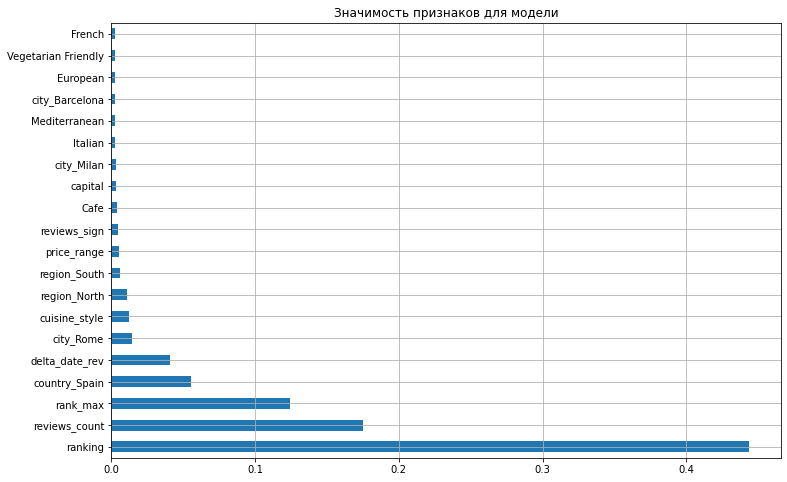

In [113]:
print('MAE:', estimate_MAE(data_test, target))

#### Проверяем, чтобы наша целевая переменная после очистки данных не деградировала

In [114]:
target.value_counts()

4.00    12285
4.50     9873
3.50     5989
5.00     3348
3.00     1049
2.50      329
2.00      153
Name: rating, dtype: int64

# Пробуем уменьшить значение MAE через нормирование данных

In [115]:
# Нормализация значений методом MinMax 
#scaler = MinMaxScaler()

# Нормализация значений методом STD 
#scaler = StandardScaler()

In [116]:
'''
a = scaler.fit_transform(df_new[['reviews_count','delta_date_rev']]).T

# Создаём новый столбец (признак): нормированный признак reviews_count
df_new['reviews_count_norm'] = a[0]

# Создаём новый столбец (признак): нормированный признак delta_date_rev
df_new['delta_date_rev_norm'] = a[1]

# Готовим входные данные для проверки модели:
data_test = df_new.drop(['rating', 'restaurant_id', 'reviews', 'url_ta', 'id_ta', 'ranking', 'reviews_count', 
                         'delta_date_rev'], axis = 1)
# 2. Целевая переменная - "rating"
target = df['rating']

print('MAE:', estimate_MAE(data_test, target))
'''

'\na = scaler.fit_transform(df_new[[\'reviews_count\',\'delta_date_rev\']]).T\n\n# Создаём новый столбец (признак): нормированный признак reviews_count\ndf_new[\'reviews_count_norm\'] = a[0]\n\n# Создаём новый столбец (признак): нормированный признак delta_date_rev\ndf_new[\'delta_date_rev_norm\'] = a[1]\n\n# Готовим входные данные для проверки модели:\ndata_test = df_new.drop([\'rating\', \'restaurant_id\', \'reviews\', \'url_ta\', \'id_ta\', \'ranking\', \'reviews_count\', \n                         \'delta_date_rev\'], axis = 1)\n# 2. Целевая переменная - "rating"\ntarget = df[\'rating\']\n\nprint(\'MAE:\', estimate_MAE(data_test, target))\n'

In [117]:
'''
# Создание словаря с шагом деления по городам
step_city = {}
for city in (df['city'].value_counts()).index:
    step_city[city] = int(df[df['city'] == city]['ranking'].max() / 100) + 1

# Разбивка рейтинга города на 100 диапазонов
df['rank_100'] = df.apply(lambda x: int(x['ranking'] / step_city[x['city']]) + 1, axis = 1)
'''

"\n# Создание словаря с шагом деления по городам\nstep_city = {}\nfor city in (df['city'].value_counts()).index:\n    step_city[city] = int(df[df['city'] == city]['ranking'].max() / 100) + 1\n\n# Разбивка рейтинга города на 100 диапазонов\ndf['rank_100'] = df.apply(lambda x: int(x['ranking'] / step_city[x['city']]) + 1, axis = 1)\n"

In [118]:
'''
# Создание словаря с минимальным и максимальным значением по городам
dict_city = {}
for city in (df['city'].value_counts()).index:
    df_tmp = df['ranking'][df['city'] == city]
    dict_city[city] = [df_tmp.min(), df_tmp.max()]

# MinMax нормирование признака ranking
df['rank_norm'] = df.apply(lambda x: 
                           (x['ranking']-dict_city[x['city']][0]) / (dict_city[x['city']][1]-dict_city[x['city']][0]),
                            axis = 1)
'''

"\n# Создание словаря с минимальным и максимальным значением по городам\ndict_city = {}\nfor city in (df['city'].value_counts()).index:\n    df_tmp = df['ranking'][df['city'] == city]\n    dict_city[city] = [df_tmp.min(), df_tmp.max()]\n\n# MinMax нормирование признака ranking\ndf['rank_norm'] = df.apply(lambda x: \n                           (x['ranking']-dict_city[x['city']][0]) / (dict_city[x['city']][1]-dict_city[x['city']][0]),\n                            axis = 1)\n"